## Preparing the Data

Firstly, we must import the dataset into the notebook

In [1]:
import pandas as pd

dataset = pd.read_excel('OpArticles_ADUs.xlsx')

## Cleanup and normalization

The next step is to cleanup our dataset and normalize some data

#### Removing non-alphabetic chars

Let's start by removing any non-alpha chars, using a regular expression. We'll create a separate corpus (a list of tokens), so that we leave the original dataset untouched.

#### Lowercasing

We can then apply lowercasing, so that words such as *Amazing*, *AMAZING* and *amazing* all have the same representation.

#### Removing stop words

Another common step which is sometimes applied is to remove any stop words (words that do not have domain semantics attached). We can use the stop words list provided in NLTK for English:

#### Stemming

Finally, we can apply stemming to further reduce the size of the vocabulary through normalization.

In [46]:
import re
from nltk.stem import RSLPStemmer
from nltk.corpus import stopwords

stopwords_list = stopwords.words('portuguese')
stopwords_list.remove('não')

def preprocess(df):
    corpus = []
    stemmer = RSLPStemmer()
    for i in range(0, df['tokens'].size):
        # get review and remove non alpha chars
        review = re.sub('[^a-zA-Z\u00C0-\u00ff]', ' ', df['tokens'][i])
        # to lower-case 
        review = review.lower()
        # split into tokens, apply stemming and remove stop words
        review = ' '.join([stemmer.stem(w) for w in review.split() if not w in set(stopwords_list)])
        corpus.append(review)
    
    return corpus

In [3]:
corpus = preprocess(dataset)
print(corpus[:5])

['fact não apen frut ignor', 'hav hum jorn investig preocup aprofund contextual histór isenç relat preocup soc urg denunci muit peç real jorn', 'tud cómic fif', 'tod permit organiz faç total absurd sent', 'não faz rir cust poder']


### Wordclouds

Some analysis after the corpus preprocess

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
def draw_wc(text):
    wordcloud = WordCloud(width = 1920, height = 1080,
                    background_color ='black',
                    stopwords = stopwords.words('portuguese'),
                    colormap='Set2',
                    min_font_size = 10).generate(text)

    plt.figure(figsize = (16, 9))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad = 0)
    plt.show()

Corpus

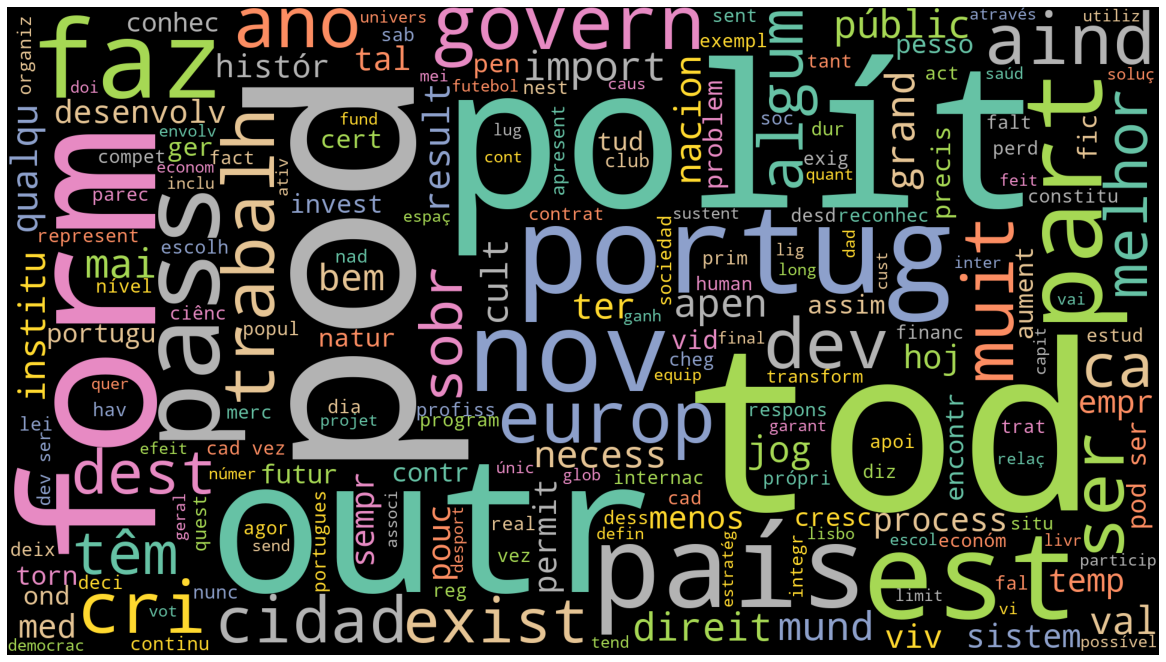

In [6]:
draw_wc(" ".join(corpus))

#### Fact

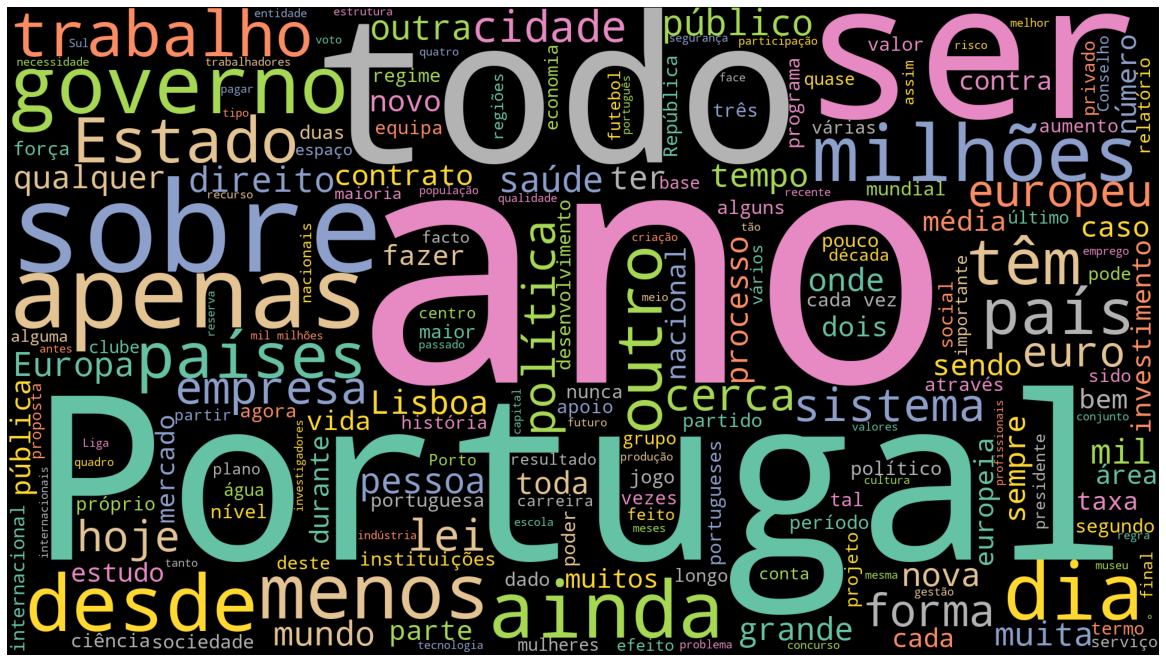

In [7]:
draw_wc(" ".join(dataset[dataset['label'] == 'Fact']['tokens']))

#### Policy

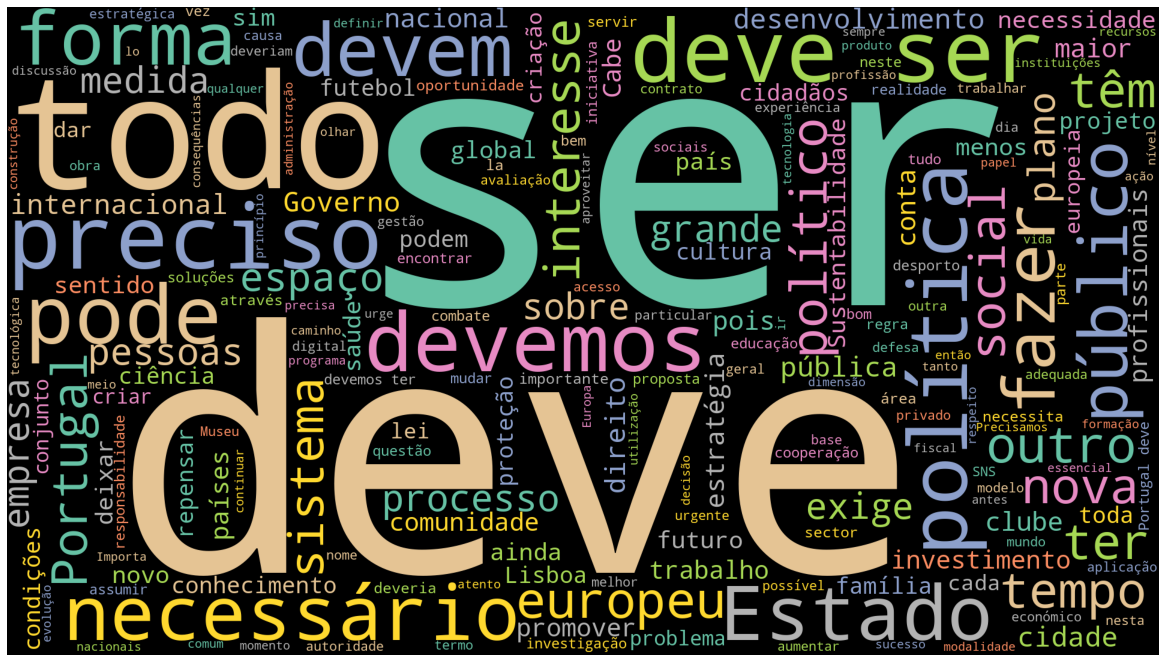

In [8]:
draw_wc(" ".join(dataset[dataset['label'] == 'Policy']['tokens']))

#### Value

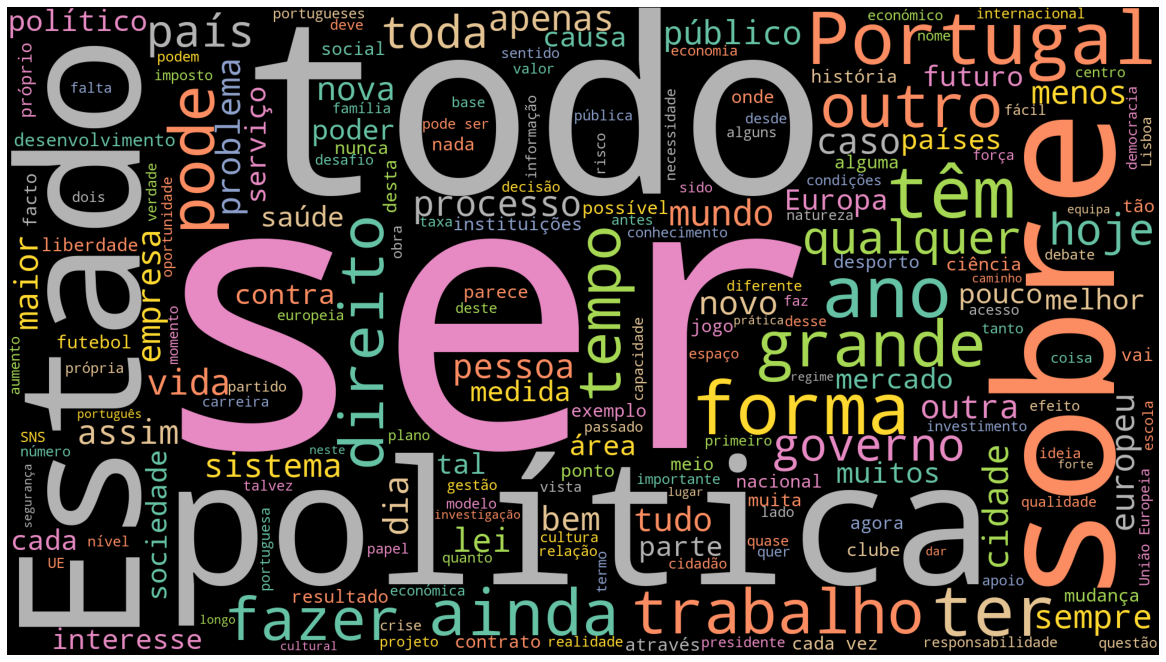

In [9]:
draw_wc(" ".join(dataset[dataset['label'] == 'Value']['tokens']))

#### Value(+)


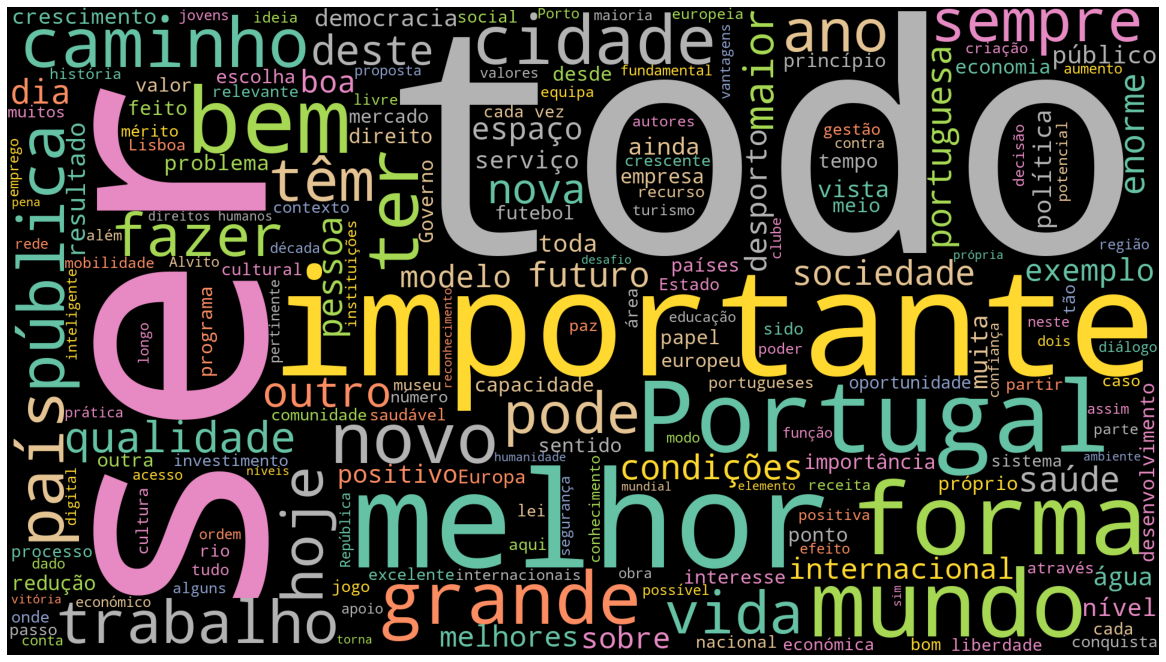

In [10]:
draw_wc(" ".join(dataset[dataset['label'] == 'Value(+)']['tokens']))

#### Value(-)

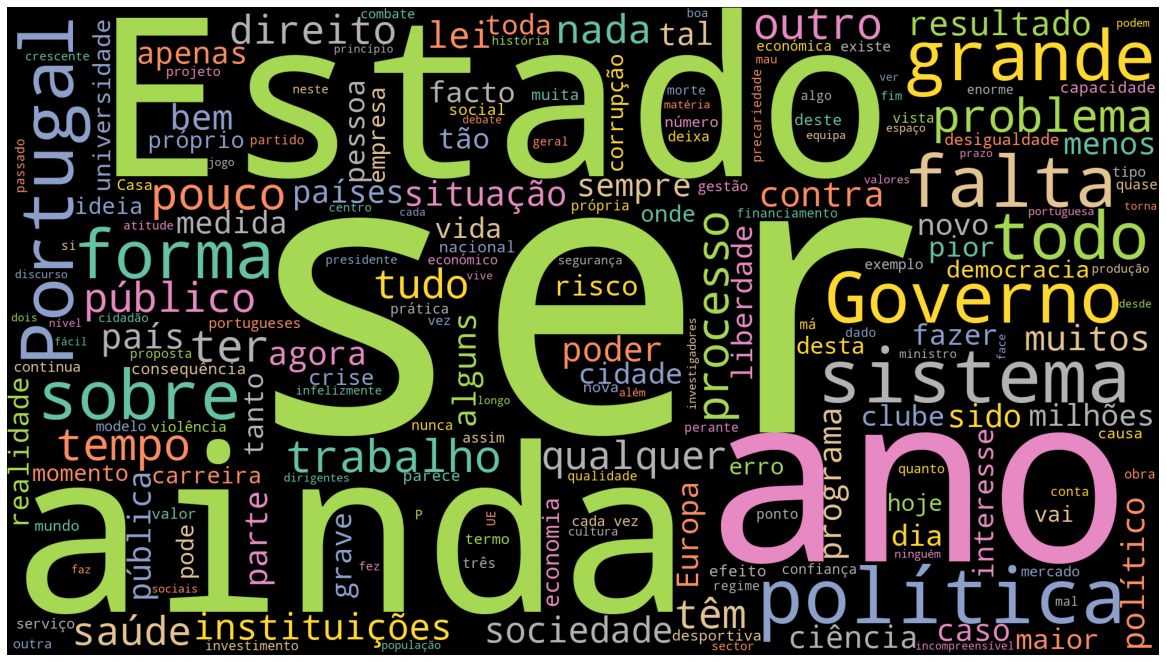

In [11]:
draw_wc(" ".join(dataset[dataset['label'] == 'Value(-)']['tokens']))

## Obtaining Features and Classes

The next step is to obtain the features we will use to train our model.

For this, we will use TF-IDF with N-Grams

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
    
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.8)
X = vectorizer.fit_transform(corpus).toarray()
y = dataset['label']

print("(Number of samples, Number of features):", X.shape)

(Number of samples, Number of features): (16743, 19262)


In [13]:
#print(vectorizer.get_feature_names())

In [14]:
print(corpus[10])
print(X[10])

discurs polít tal preocup pelej partidár mer conqu terren tal indiferenç cois verdade import
[0. 0. 0. ... 0. 0. 0.]


## Training classifiers

- *Naive Bayes*, the two most effective variants are [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and [ComplementNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html).
- *Logistic Regression*, through scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class.
- *Decision Tree*, through scikit-learn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class. This model always assigns a probability of 1 to one of the classes.
- *Random Forest*, through scikit-learn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class.
- *Support Vector Machines (SVM)*, through scikit-learn's [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class. The SVM model also allows you to get probabilities, but for that you need to use the *probability=True* parameter setting in its constructor.
- *Perceptron*, through scikit-learn's [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) class. This model does not allow you to get probabilities.
- *eXtreme Gradient Boosting*, through [XGBoost](https://xgboost.readthedocs.io/en/stable/).

In [15]:
# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from time import time

# Cross Validation and Hyper Tuning
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# Classifiers
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
import xgboost as xgb

C:\Users\fmna\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


To train machine learning classifiers, we first split the data into training and test sets.
We are using 80% of the data to create a train set, and the rest 20% for the test set.
We specify the _stratify_ parameter in order to create balanced distribution regarding labels percentages

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(13394, 19262) (13394,)
(3349, 19262) (3349,)

Label distribution in the training set:
Value       6481
Fact        2930
Value(-)    2320
Value(+)    1129
Policy       534
Name: label, dtype: int64

Label distribution in the test set:
Value       1621
Fact         733
Value(-)     580
Value(+)     282
Policy       133
Name: label, dtype: int64


### Baseline Predictions

In [17]:
def predict(clf, XT=X_train, yT=y_train):
    start_time = time()
    clf.fit(XT, yT)
    y_pred = clf.predict(X_test)
    stop_time = time()

    # Metrics
    print("Elapsed time: %0.2fs" % (stop_time - start_time))
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=clf.classes_), display_labels=clf.classes_).plot()

#### Naive Bayes

Elapsed time: 0.80s

Classification report:
               precision    recall  f1-score   support

        Fact       0.53      0.16      0.24       733
      Policy       0.00      0.00      0.00       133
       Value       0.50      0.94      0.66      1621
    Value(+)       0.83      0.02      0.03       282
    Value(-)       0.58      0.12      0.20       580

    accuracy                           0.51      3349
   macro avg       0.49      0.25      0.23      3349
weighted avg       0.53      0.51      0.41      3349



C:\Users\fmna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fmna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fmna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


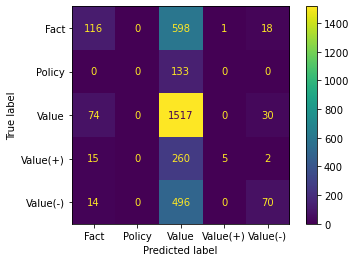

In [18]:
predict(MultinomialNB())

Elapsed time: 0.80s

Classification report:
               precision    recall  f1-score   support

        Fact       0.43      0.41      0.42       733
      Policy       0.38      0.44      0.41       133
       Value       0.60      0.60      0.60      1621
    Value(+)       0.42      0.41      0.42       282
    Value(-)       0.48      0.48      0.48       580

    accuracy                           0.52      3349
   macro avg       0.46      0.47      0.47      3349
weighted avg       0.52      0.52      0.52      3349



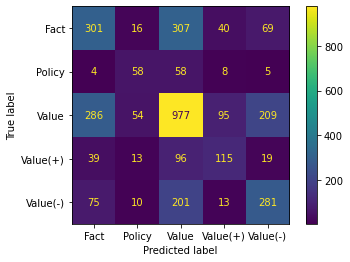

In [19]:
predict(ComplementNB())

#### SGD

Elapsed time: 25.82s

Classification report:
               precision    recall  f1-score   support

        Fact       0.46      0.31      0.37       733
      Policy       0.55      0.29      0.38       133
       Value       0.57      0.77      0.66      1621
    Value(+)       0.47      0.30      0.36       282
    Value(-)       0.52      0.37      0.43       580

    accuracy                           0.54      3349
   macro avg       0.51      0.41      0.44      3349
weighted avg       0.53      0.54      0.52      3349



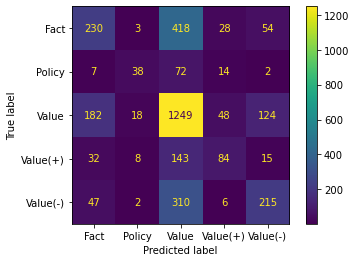

In [20]:
predict(SGDClassifier(random_state=0, n_jobs=-1))

#### Logistic Regression

Elapsed time: 194.34s

Classification report:
               precision    recall  f1-score   support

        Fact       0.47      0.30      0.36       733
      Policy       0.64      0.11      0.18       133
       Value       0.54      0.85      0.66      1621
    Value(+)       0.68      0.12      0.20       282
    Value(-)       0.53      0.25      0.34       580

    accuracy                           0.53      3349
   macro avg       0.57      0.32      0.35      3349
weighted avg       0.54      0.53      0.48      3349



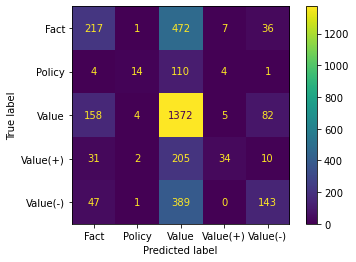

In [21]:
predict(LogisticRegression(random_state=0, n_jobs=-1))

#### SVC

C:\Users\fmna\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Elapsed time: 225.65s

Classification report:
               precision    recall  f1-score   support

        Fact       0.23      0.26      0.24       733
      Policy       0.27      0.31      0.29       133
       Value       0.49      0.70      0.58      1621
    Value(+)       0.15      0.01      0.03       282
    Value(-)       0.40      0.00      0.01       580

    accuracy                           0.41      3349
   macro avg       0.31      0.26      0.23      3349
weighted avg       0.38      0.41      0.35      3349



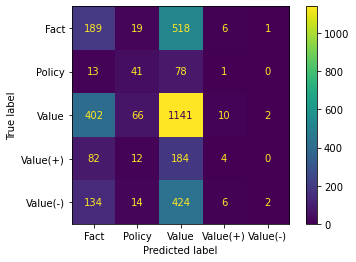

In [22]:
predict(SVC(random_state=0, max_iter=100))

#### Perceptron

Elapsed time: 20.72s

Classification report:
               precision    recall  f1-score   support

        Fact       0.38      0.39      0.38       733
      Policy       0.49      0.50      0.50       133
       Value       0.58      0.57      0.58      1621
    Value(+)       0.43      0.30      0.36       282
    Value(-)       0.43      0.49      0.46       580

    accuracy                           0.49      3349
   macro avg       0.46      0.45      0.46      3349
weighted avg       0.50      0.49      0.49      3349



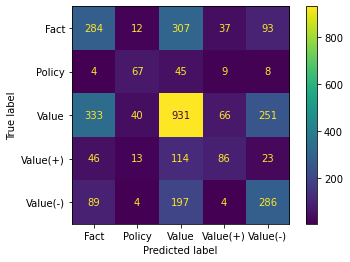

In [23]:
predict(Perceptron(random_state=0, n_jobs=-1))

#### Decision Tree

Elapsed time: 793.28s

Classification report:
               precision    recall  f1-score   support

        Fact       0.37      0.39      0.38       733
      Policy       0.49      0.44      0.46       133
       Value       0.56      0.61      0.58      1621
    Value(+)       0.40      0.32      0.36       282
    Value(-)       0.43      0.34      0.38       580

    accuracy                           0.48      3349
   macro avg       0.45      0.42      0.43      3349
weighted avg       0.48      0.48      0.48      3349



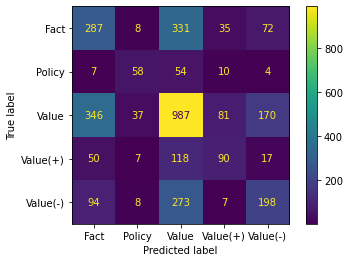

In [24]:
predict(DecisionTreeClassifier(random_state=0))

#### Random Forest

Elapsed time: 242.21s

Classification report:
               precision    recall  f1-score   support

        Fact       0.45      0.31      0.37       733
      Policy       0.65      0.39      0.49       133
       Value       0.56      0.75      0.65      1621
    Value(+)       0.48      0.31      0.38       282
    Value(-)       0.52      0.37      0.43       580

    accuracy                           0.54      3349
   macro avg       0.53      0.43      0.46      3349
weighted avg       0.53      0.54      0.52      3349



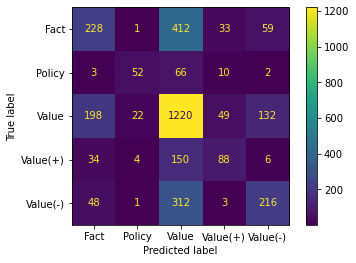

In [25]:
predict(RandomForestClassifier(random_state=0, n_jobs=-1))

#### K Nearest Neighbors

Elapsed time: 14.88s

Classification report:
               precision    recall  f1-score   support

        Fact       0.29      0.37      0.33       733
      Policy       0.60      0.09      0.16       133
       Value       0.52      0.57      0.54      1621
    Value(+)       0.19      0.17      0.18       282
    Value(-)       0.32      0.21      0.25       580

    accuracy                           0.41      3349
   macro avg       0.38      0.28      0.29      3349
weighted avg       0.41      0.41      0.40      3349



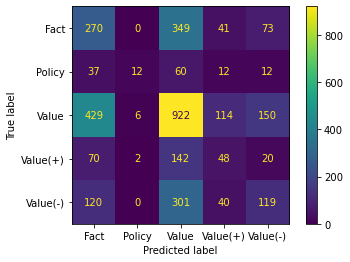

In [26]:
predict(KNeighborsClassifier(n_jobs=-1))

#### XGBoost

C:\Users\fmna\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time: 605.67s

Classification report:
               precision    recall  f1-score   support

        Fact       0.53      0.16      0.25       733
      Policy       0.58      0.26      0.36       133
       Value       0.52      0.90      0.66      1621
    Value(+)       0.42      0.09      0.15       282
    Value(-)       0.52      0.15      0.24       580

    accuracy                           0.52      3349
   macro avg       0.51      0.31      0.33      3349
weighted avg       0.51      0.52      0.44      3349



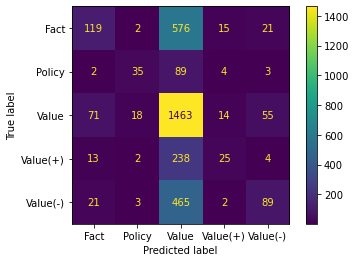

In [27]:
predict(xgb.XGBClassifier())

## Balance Dataset

### Undersample

In [28]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=0)
X_train_RUS, y_train_RUS = under_sampler.fit_resample(X_train, y_train)

print(X_train_RUS.shape, y_train_RUS.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train_RUS.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())


(2670, 19262) (2670,)
(3349, 19262) (3349,)

Label distribution in the training set:
Fact        534
Policy      534
Value       534
Value(+)    534
Value(-)    534
Name: label, dtype: int64

Label distribution in the test set:
Value       1621
Fact         733
Value(-)     580
Value(+)     282
Policy       133
Name: label, dtype: int64


Elapsed time: 5.45s

Classification report:
               precision    recall  f1-score   support

        Fact       0.34      0.35      0.34       733
      Policy       0.24      0.73      0.36       133
       Value       0.59      0.30      0.39      1621
    Value(+)       0.18      0.51      0.26       282
    Value(-)       0.33      0.32      0.33       580

    accuracy                           0.35      3349
   macro avg       0.34      0.44      0.34      3349
weighted avg       0.44      0.35      0.36      3349



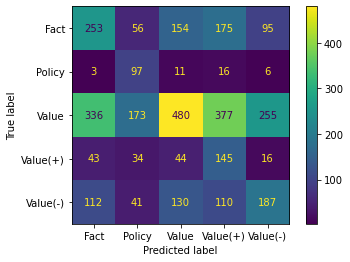

In [29]:
predict(SGDClassifier(random_state=0, n_jobs=-1), X_train_RUS, y_train_RUS)

In [30]:
from imblearn.under_sampling import NearMiss
under_sampler = NearMiss()
X_train_NM, y_train_NM = under_sampler.fit_resample(X_train, y_train)

print(X_train_NM.shape, y_train_NM.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train_NM.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(2670, 19262) (2670,)
(3349, 19262) (3349,)

Label distribution in the training set:
Fact        534
Policy      534
Value       534
Value(+)    534
Value(-)    534
Name: label, dtype: int64

Label distribution in the test set:
Value       1621
Fact         733
Value(-)     580
Value(+)     282
Policy       133
Name: label, dtype: int64


Elapsed time: 6.36s

Classification report:
               precision    recall  f1-score   support

        Fact       0.29      0.53      0.37       733
      Policy       0.35      0.63      0.45       133
       Value       0.61      0.07      0.13      1621
    Value(+)       0.17      0.46      0.25       282
    Value(-)       0.30      0.41      0.34       580

    accuracy                           0.29      3349
   macro avg       0.34      0.42      0.31      3349
weighted avg       0.44      0.29      0.24      3349



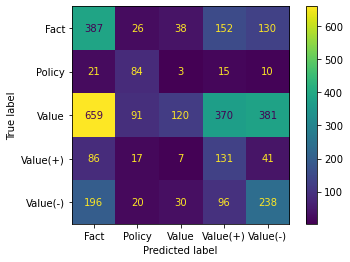

In [31]:
predict(SGDClassifier(random_state=0, n_jobs=-1), X_train_NM, y_train_NM)

### Oversample

In [32]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=0)
X_train_ROS, y_train_ROS = over_sampler.fit_resample(X_train, y_train)

print(X_train_ROS.shape, y_train_ROS.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train_ROS.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(32405, 19262) (32405,)
(3349, 19262) (3349,)

Label distribution in the training set:
Value       6481
Value(-)    6481
Fact        6481
Policy      6481
Value(+)    6481
Name: label, dtype: int64

Label distribution in the test set:
Value       1621
Fact         733
Value(-)     580
Value(+)     282
Policy       133
Name: label, dtype: int64


Elapsed time: 27.63s

Classification report:
               precision    recall  f1-score   support

        Fact       0.42      0.46      0.44       733
      Policy       0.33      0.65      0.44       133
       Value       0.65      0.38      0.48      1621
    Value(+)       0.28      0.56      0.37       282
    Value(-)       0.40      0.53      0.45       580

    accuracy                           0.45      3349
   macro avg       0.42      0.51      0.44      3349
weighted avg       0.51      0.45      0.46      3349



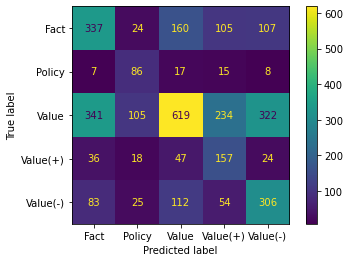

In [33]:
predict(SGDClassifier(random_state=0, n_jobs=-1), X_train_ROS, y_train_ROS)

In [34]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE()
X_train_SMT, y_train_SMT = over_sampler.fit_resample(X_train, y_train)

print(X_train_SMT.shape, y_train_SMT.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train_SMT.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(32405, 19262) (32405,)
(3349, 19262) (3349,)

Label distribution in the training set:
Value       6481
Value(-)    6481
Fact        6481
Policy      6481
Value(+)    6481
Name: label, dtype: int64

Label distribution in the test set:
Value       1621
Fact         733
Value(-)     580
Value(+)     282
Policy       133
Name: label, dtype: int64


Elapsed time: 28.61s

Classification report:
               precision    recall  f1-score   support

        Fact       0.42      0.46      0.44       733
      Policy       0.33      0.65      0.44       133
       Value       0.65      0.38      0.48      1621
    Value(+)       0.28      0.56      0.37       282
    Value(-)       0.40      0.53      0.45       580

    accuracy                           0.45      3349
   macro avg       0.42      0.51      0.44      3349
weighted avg       0.51      0.45      0.46      3349



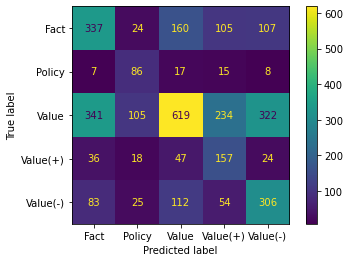

In [35]:
predict(SGDClassifier(random_state=0, n_jobs=-1), X_train_ROS, y_train_ROS)

## Parameter tuning

To further improve the best models we explored different parameters within each classifier.

TODO [explore more scoring methods](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [36]:
def grid_search(clf, parameter_grid):
    grid_search = GridSearchCV(clf,
                               param_grid=parameter_grid,
                               scoring='f1_weighted',
                               cv=StratifiedKFold(n_splits=5),
                               verbose=4,
                               n_jobs=4,
                               refit=True)

    start_time = time()
    grid_search.fit(X_train, y_train)
    stop_time = time()
    print(f"Fit time: %0.2fs" % (stop_time - start_time))

    print("\nBest score:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    print("Best estimator:", grid_search.best_estimator_)
    
    best_model = grid_search.best_estimator_
    best_model_pred = best_model.predict(X_test)

    # Metrics
    print("\nClassification report:\n", classification_report(y_test, best_model_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, best_model_pred, labels=clf.classes_), display_labels=clf.classes_).plot()


#### SGD

In [37]:
# The ‘log’ loss gives logistic regression, ‘perceptron’ is the linear loss used by the perceptron algorithm

""" grid_search(
    SGDClassifier(random_state=0, n_jobs=-1, early_stopping=True),
    {
        'loss': ['log', 'hinge', 'perceptron'],
        'penalty': ['elasticnet', 'l1', 'l2'],
        'class_weight': [None, 'balanced']
    }
) """

" grid_search(\n    SGDClassifier(random_state=0, n_jobs=-1, early_stopping=True),\n    {\n        'loss': ['log', 'hinge', 'perceptron'],\n        'penalty': ['elasticnet', 'l1', 'l2'],\n        'class_weight': [None, 'balanced']\n    }\n) "

#### Logistic Regression

takes too long

In [38]:
""" grid_search(
    LogisticRegression(random_state=0, n_jobs=-1),
    {
        'solver': ['saga'],
        'penalty': ['elasticnet', 'l1', 'l2'],
        'class_weight': [None, 'balanced']
    }
) """

" grid_search(\n    LogisticRegression(random_state=0, n_jobs=-1),\n    {\n        'solver': ['saga'],\n        'penalty': ['elasticnet', 'l1', 'l2'],\n        'class_weight': [None, 'balanced']\n    }\n) "

### Random Forest

In [39]:
""" grid_search(
    RandomForestClassifier(random_state=0, n_jobs=-1),
    {
        'criterion': ['gini','entropy'],
        'max_features': ['sqrt', 'log2'],
        'class_weight': [None, 'balanced']
    }
) """

" grid_search(\n    RandomForestClassifier(random_state=0, n_jobs=-1),\n    {\n        'criterion': ['gini','entropy'],\n        'max_features': ['sqrt', 'log2'],\n        'class_weight': [None, 'balanced']\n    }\n) "

## Training models per annotator and using ensemble

Separating each annotator's judgment will make the task of training the model significantly easier and faster, since we are dealing with less data. At the end of the training, we will use ensemble methods, such as voting, to make a more accurate prediction, by using the predictions of each trained model to reach a consensus on a label.

In [40]:
X_annotated = pd.concat([dataset['annotator'], pd.DataFrame(X)], axis=1)

print(X_annotated)

      annotator    0    1    2    3    4    5    6    7    8  ...  19252  \
0             A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
1             A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
2             A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
3             A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
4             A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
16738         D  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
16739         D  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
16740         D  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
16741         D  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
16742         D  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   

       19253  19254  19255  19256  19257  19258  19259  19260  19261  
0        0.0    

In [41]:
X_A = X_annotated[X_annotated['annotator'] == 'A']
X_A = X_A.drop('annotator', 1)
y_A = dataset.loc[dataset['annotator'] == 'A', 'label']

X_B = X_annotated[X_annotated['annotator'] == 'B']
X_B = X_B.drop('annotator', 1)
y_B = dataset.loc[dataset['annotator'] == 'B', 'label']

X_C = X_annotated[X_annotated['annotator'] == 'C']
X_C = X_C.drop('annotator', 1)
y_C = dataset.loc[dataset['annotator'] == 'C', 'label']

X_D = X_annotated[X_annotated['annotator'] == 'D']
X_D = X_D.drop('annotator', 1)
y_D = dataset.loc[dataset['annotator'] == 'D', 'label']

print(X_A.shape)
print(y_A.shape)

C:\Users\fmna\AppData\Local\Temp\ipykernel_8100\437081877.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_A = X_A.drop('annotator', 1)
C:\Users\fmna\AppData\Local\Temp\ipykernel_8100\437081877.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_B = X_B.drop('annotator', 1)
C:\Users\fmna\AppData\Local\Temp\ipykernel_8100\437081877.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_C = X_C.drop('annotator', 1)
C:\Users\fmna\AppData\Local\Temp\ipykernel_8100\437081877.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_D = X_D.drop('annotator', 1)


(3335, 19262)
(3335,)


In [42]:
X_A_tr, X_A_te, y_A_tr, y_A_te = train_test_split(X_A, y_A, test_size=0.20, random_state=0, stratify=y_A)

X_B_tr, X_B_te, y_B_tr, y_B_te = train_test_split(X_B, y_B, test_size=0.20, random_state=0, stratify=y_B)

X_C_tr, X_C_te, y_C_tr, y_C_te = train_test_split(X_C, y_C, test_size=0.20, random_state=0, stratify=y_C)

X_D_tr, X_D_te, y_D_tr, y_D_te = train_test_split(X_D, y_D, test_size=0.20, random_state=0, stratify=y_D)

Now we can procede to use Voting in order to obtain a better prediction:

C:\Users\fmna\anaconda3\lib\site-packages\mlxtend\classifier\ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


Classification report:
               precision    recall  f1-score   support

        Fact       0.80      0.21      0.34      3663
      Policy       0.87      0.04      0.08       667
       Value       0.52      0.99      0.68      8102
    Value(+)       0.93      0.04      0.07      1411
    Value(-)       0.89      0.13      0.22      2900

    accuracy                           0.55     16743
   macro avg       0.80      0.28      0.28     16743
weighted avg       0.69      0.55      0.45     16743



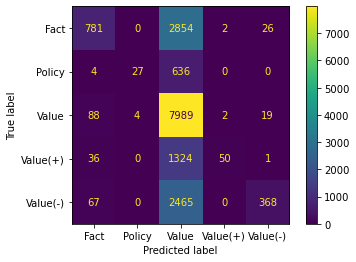

In [43]:
from mlxtend.classifier import EnsembleVoteClassifier
import copy

clf_A = SGDClassifier(random_state=0, n_jobs=-1, loss="log")
clf_A.fit(X_A_tr, y_A_tr)

clf_B = SGDClassifier(random_state=0, n_jobs=-1, loss="log")
clf_B.fit(X_B_tr, y_B_tr)

clf_C = SGDClassifier(random_state=0, n_jobs=-1, loss="log")
clf_C.fit(X_C_tr, y_C_tr)

clf_D = SGDClassifier(random_state=0, n_jobs=-1, loss="log")
clf_D.fit(X_D_tr, y_D_tr)

eclf = EnsembleVoteClassifier(clfs=[clf_A, clf_B, clf_C, clf_D], fit_base_estimators=False, voting='soft')
eclf.fit(X,y)
y_pred_vote = eclf.predict(X)

print("Classification report:\n", classification_report(y, y_pred_vote))
ConfusionMatrixDisplay(confusion_matrix(y, y_pred_vote, labels=eclf.classes_), display_labels=eclf.classes_).plot()

## Removing minorities

Next, we will remove the entries of the annotators that will be in a minority, refering to the classification of a label. Our idea was that if a majority of the annotators agrees with a label, then it must be the correct one and we can discord the ones which contradict it.
this will limit the amount of data we will work with, by grouping data by tokens and labels, and count the max number of annotators per token-label pair. 

In [47]:
df_tmp = dataset.groupby(['tokens', 'label']).agg({'annotator': 'count'}).reset_index()

dataset_no_duplicates = df_tmp.groupby(['tokens'], as_index=False).agg({'annotator': 'max', 'label': 'first'})
dataset_no_duplicates = dataset_no_duplicates.drop('annotator', 1)

corpus = preprocess(dataset_no_duplicates)
    
X = vectorizer.fit_transform(corpus).toarray()
y = dataset_no_duplicates['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y, shuffle=True)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

C:\Users\fmna\AppData\Local\Temp\ipykernel_8100\1320113039.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset_no_duplicates = dataset_no_duplicates.drop('annotator', 1)


(9606, 8054) (9606,)
(2402, 8054) (2402,)

Label distribution in the training set:
Value       4537
Fact        2549
Value(-)    1412
Value(+)     678
Policy       430
Name: label, dtype: int64

Label distribution in the test set:
Value       1135
Fact         637
Value(-)     353
Value(+)     170
Policy       107
Name: label, dtype: int64


Elapsed time: 9.05s

Classification report:
               precision    recall  f1-score   support

        Fact       0.49      0.39      0.43       637
      Policy       0.34      0.21      0.26       107
       Value       0.53      0.74      0.62      1135
    Value(+)       0.34      0.13      0.19       170
    Value(-)       0.42      0.23      0.29       353

    accuracy                           0.50      2402
   macro avg       0.42      0.34      0.36      2402
weighted avg       0.48      0.50      0.48      2402



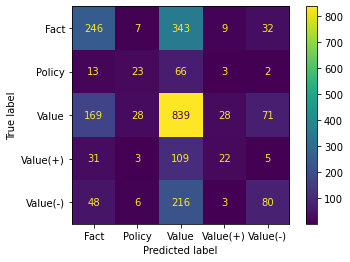

In [48]:
predict(SGDClassifier(random_state=0, n_jobs=-1), X_train, y_train)